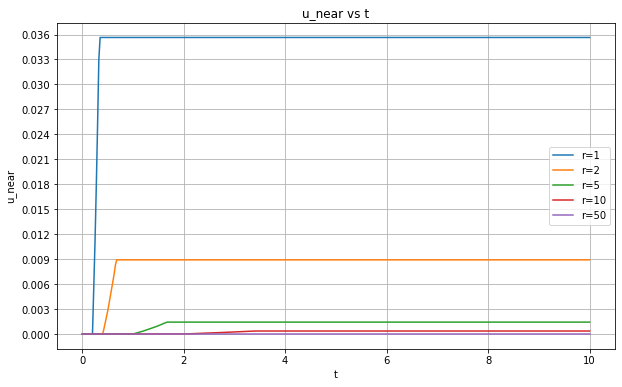

In [1]:
#ヘビサイドの階段関数
import numpy as np
import matplotlib.pyplot as plt

# 定数を定義
alpha = 5
beta = 3
N = 100
r_values = [1, 2, 5, 10, 50]

# u_nearの式を計算する関数
def calculate_u_near(r, t):
    total = 0
    for k in range(1, N+1):
        term = (1/beta - 1/alpha)/N  * (1/alpha + (1/beta - 1/alpha) * k/N) *np.heaviside(t - r/alpha - (r/beta - r/alpha)*k/N , 0) * 1/r**2
        total += term
    return total

# tの範囲とステップを定義
t_values = np.linspace(0, 10, 400)  # 例として0から10までの範囲でtを変動させる

# 各rの値に対するu_nearの値を計算しプロット
plt.figure(figsize=(10,6))
for r in r_values:
    u_near_values = [calculate_u_near(r, t) for t in t_values]
    plt.plot(t_values, u_near_values, label=f'r={r}')

plt.xlabel('t')
plt.ylabel('u_near')
plt.yticks(np.arange(0, 0.037, 0.003))
plt.title('u_near vs t')
plt.legend()
plt.grid(True)
plt.show()


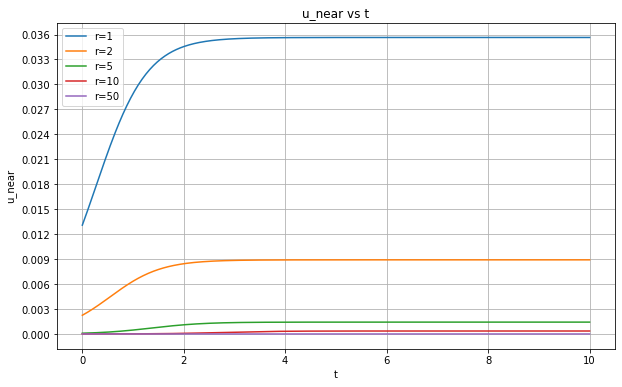

In [2]:
#ランプ関数(1/2(1+tanh(t)))
import numpy as np
import matplotlib.pyplot as plt

# 定数を定義
alpha = 5
beta = 3
N = 100
r_values = [1, 2, 5, 10, 50]

# u_nearの式を計算する関数
def calculate_u_near(r, t):
    total = 0
    for k in range(1, N+1):
        term = (1/beta - 1/alpha)/N  * (1/alpha + (1/beta - 1/alpha) * k/N) * 1/2 * ( 1 + np.tanh(t - r/alpha - (r/beta - r/alpha)*k/N)) * 1/r**2
        total += term
    return total

# tの範囲とステップを定義
t_values = np.linspace(0, 10, 400)  # 例として0から10までの範囲でtを変動させる

# 各rの値に対するu_nearの値を計算しプロット
plt.figure(figsize=(10,6))
for r in r_values:
    u_near_values = [calculate_u_near(r, t) for t in t_values]
    plt.plot(t_values, u_near_values, label=f'r={r}')

plt.xlabel('t')
plt.ylabel('u_near')
plt.yticks(np.arange(0, 0.037, 0.003))
plt.title('u_near vs t')
plt.legend()
plt.grid(True)
plt.show()


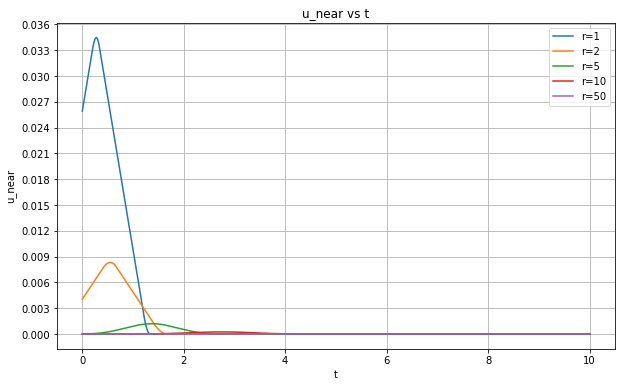

In [3]:
#三角形関数(max(1-|t|, 0))
import numpy as np
import matplotlib.pyplot as plt

# 定数を定義
alpha = 5
beta = 3
N = 100
r_values = [1, 2, 5, 10, 50]

# u_nearの式を計算する関数
def calculate_u_near(r, t):
    total = 0
    for k in range(1, N+1):
        term = (1/beta - 1/alpha)/N  * (1/alpha + (1/beta - 1/alpha) * k/N) * np.maximum(1-  np.abs(t - r/alpha - (r/beta - r/alpha)*k/N), 0) * 1/r**2
        total += term
    return total

# tの範囲とステップを定義
t_values = np.linspace(0, 10, 400)  # 例として0から10までの範囲でtを変動させる

# 各rの値に対するu_nearの値を計算しプロット
plt.figure(figsize=(10,6))
for r in r_values:
    u_near_values = [calculate_u_near(r, t) for t in t_values]
    plt.plot(t_values, u_near_values, label=f'r={r}')

plt.xlabel('t')
plt.ylabel('u_near')
plt.yticks(np.arange(0, 0.037, 0.003))
plt.title('u_near vs t')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


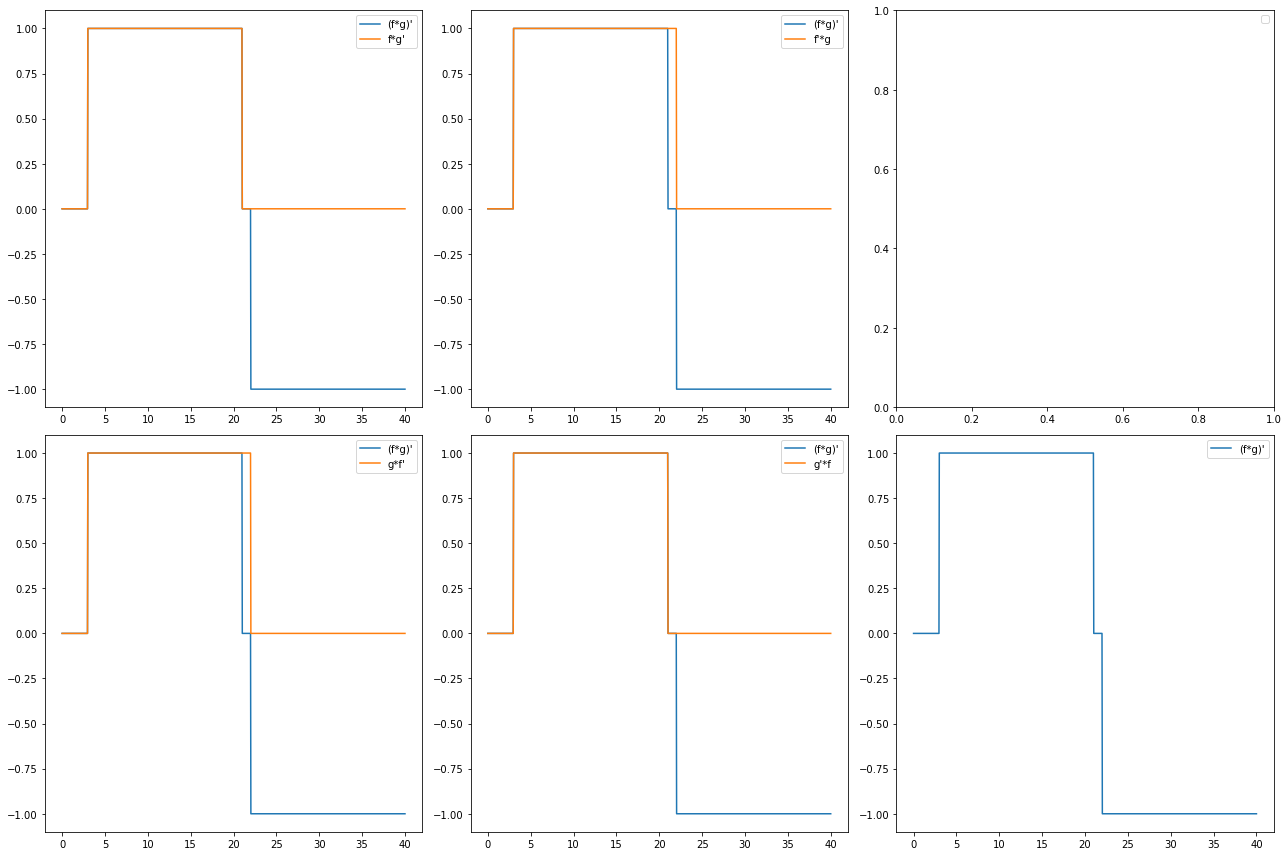

In [4]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Analytical functions
def f(x):
    return np.heaviside(x - 2, 1)

def g(x):
    return np.heaviside(x - 1, 1)

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


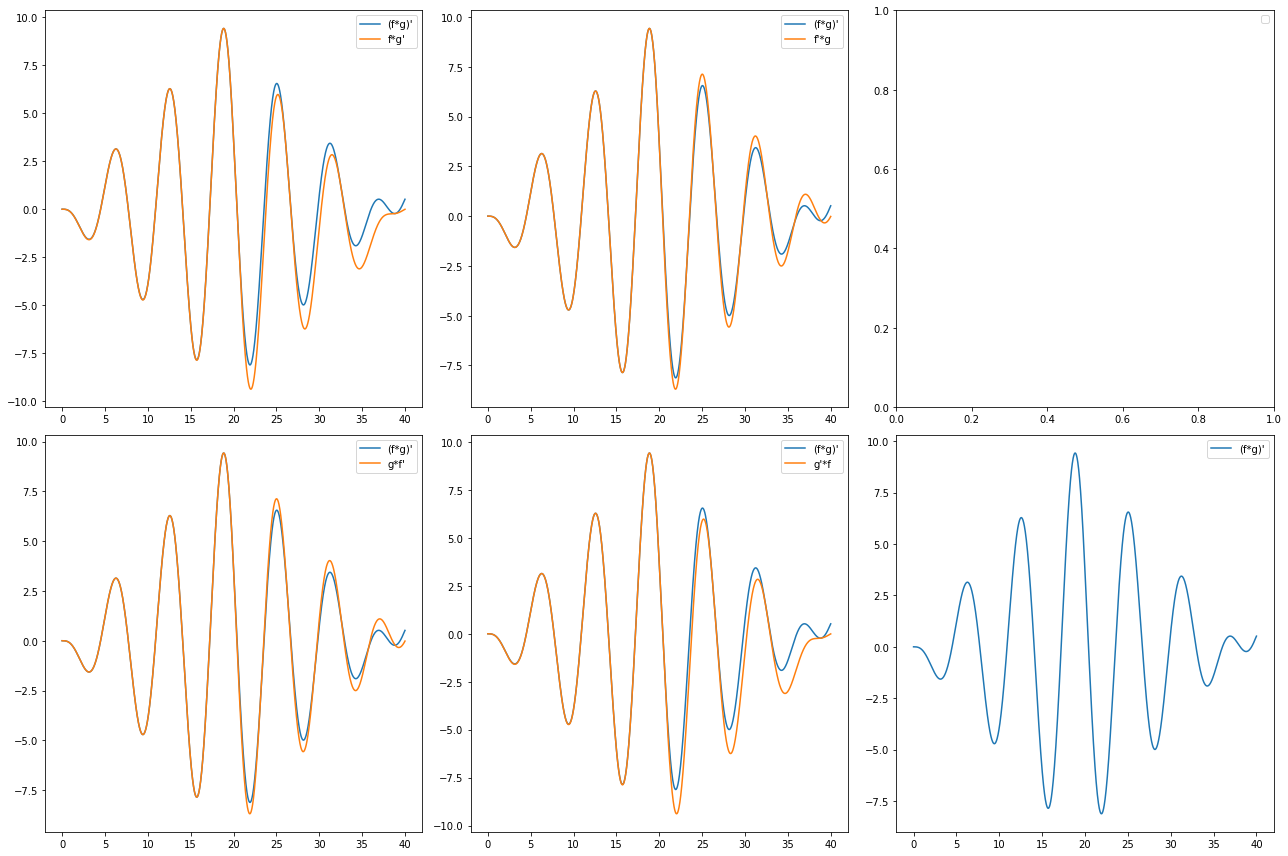

In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Analytical functions
def f(x):
    return np.cos(x) - 1

def g(x):
    return np.sin(x)

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


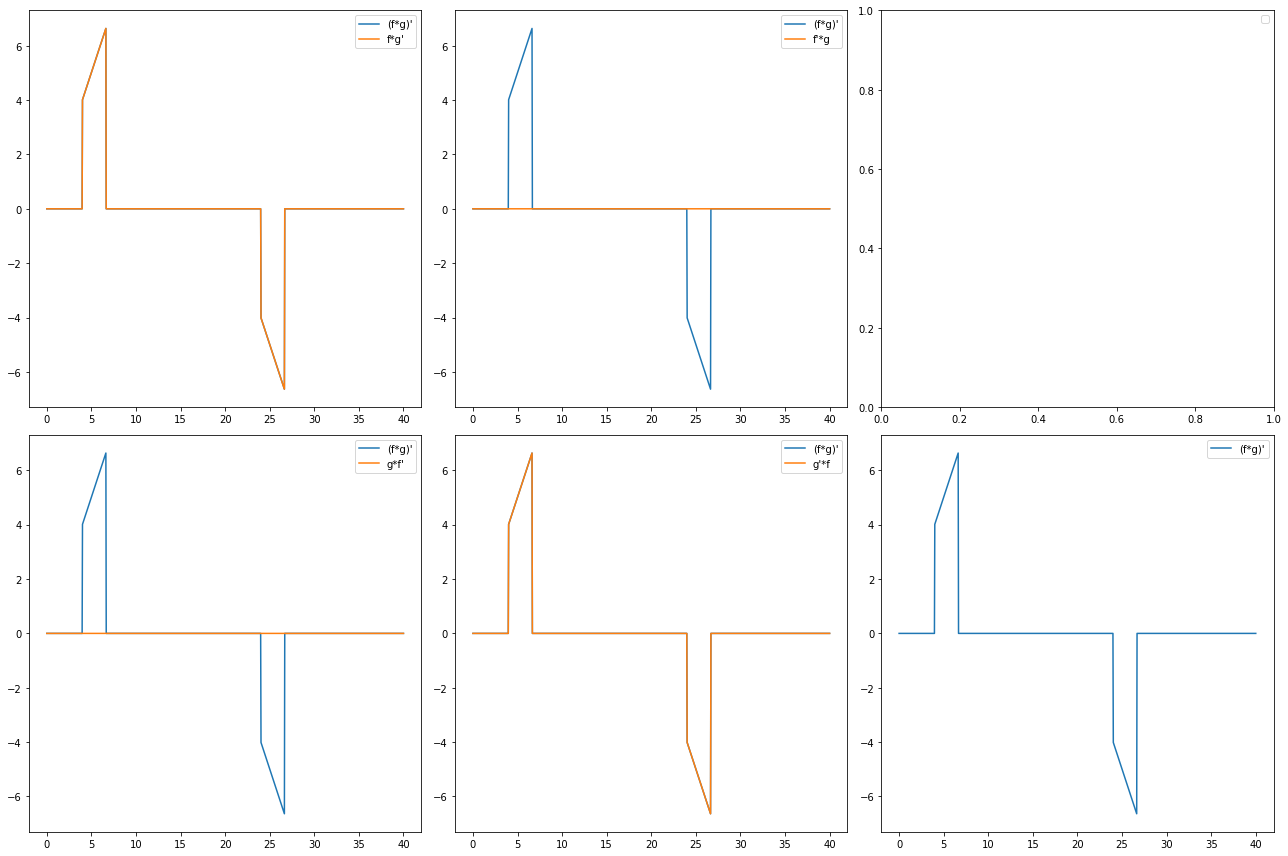

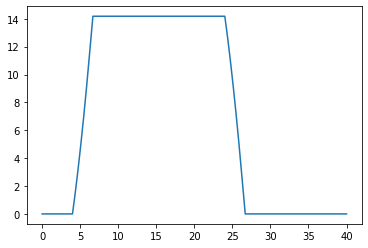

In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    return np.heaviside(x , 1)

def g(x):
    return x * (np.heaviside(x - r /alpha, 1) - np.heaviside(x -  r / beta, 1))

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()

plt.plot(x_full, conv, label = "simple conv")
plt.show()


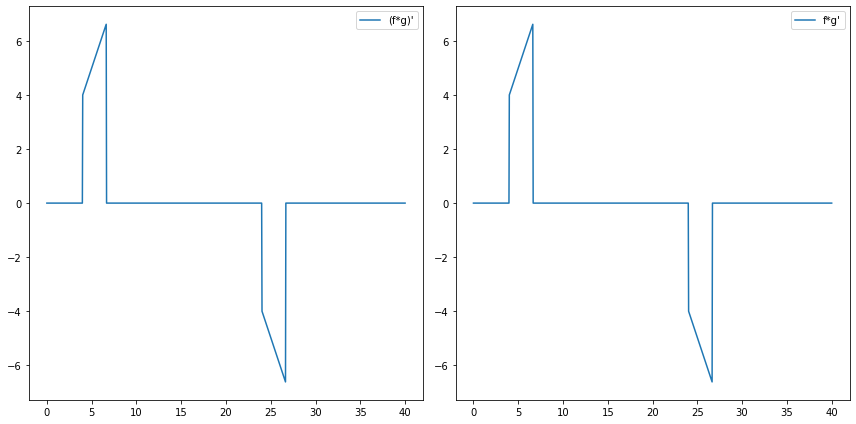

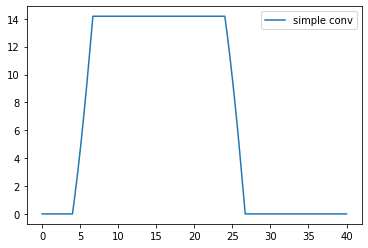

In [6]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    return np.heaviside(x , 1)

def g(x):
    return x * (np.heaviside(x - r / alpha, 1) - np.heaviside(x - r / beta, 1))

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in the first subplot
axs[0].plot(x_full, d_conv, label="(f*g)'")

# Plot f*g' in the second subplot
axs[1].plot(x_full, f_der_g, label="f*g'")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()

# Plot simple convolution
plt.plot(x_full, conv, label="simple conv")
plt.legend()
plt.show()


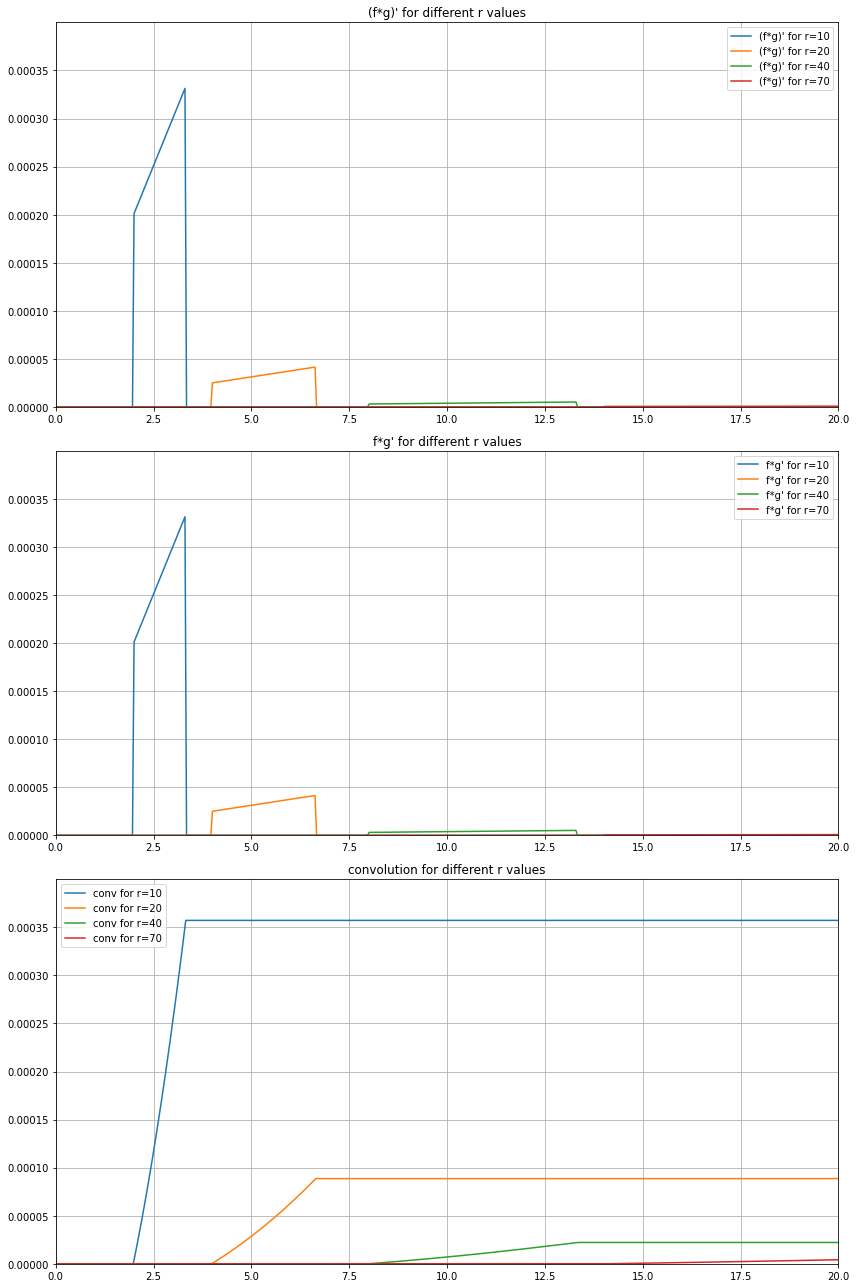

In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Parameters
alpha = 5
beta = 3
r_values = [10, 20, 40, 70]

# Analytical functions
def f(x):
    return np.heaviside(x, 1)

def g(x, r):
    return x * (np.heaviside(x - r / alpha, 1) - np.heaviside(x - r / beta, 1)) / r ** 4

# x range and small change
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Adjust the range
x_full = np.linspace(0, 40, len(x) * 2 - 1)

# Create figure and subplots for plotting the results
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Lists to store max values
max_values = []
max_x_values = []

# 新しいリストを作成
max_values_conv = []
max_x_values_conv = []

for r in r_values:
    # Calculate the derivatives using numpy's gradient function
    f_prime_x = np.gradient(f(x), dx)
    g_prime_x = np.gradient(g(x, r), dx)

    # Calculate the convolution of functions f and g
    conv = signal.convolve(f(x), g(x, r), mode='full') * dx

    # Calculate the derivative of the convolution
    d_conv = np.gradient(conv, dx)

    # Get and store the max value and the x value at that point
    max_value = np.max(d_conv)
    max_x_value = x_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_x_values.append(max_x_value)
    
    #変位の方の最大値
    max_value_conv = np.max(conv)
    max_x_value_conv = x_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_x_values_conv.append(max_x_value_conv)

    # Compute convolution of f and derivative of g
    f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx

    # Plot in the first and second subplots
    axs[0].plot(x_full, d_conv, label=f"(f*g)' for r={r}")
    axs[1].plot(x_full, f_der_g, label=f"f*g' for r={r}")

    # Plot simple convolution in the third subplot
    axs[2].plot(x_full, conv, label=f"conv for r={r}")

# Function to fit: y = b/(x-a)**2
def func(x, a, b):
    return b / (x - a)**2

# Use curve_fit to find the best a and b
params, params_covariance = curve_fit(func, max_x_values, max_values)

# Best a and b
a_opt, b_opt = params

# x values for plotting the fitted function
x_fit = np.linspace(min(max_x_values), max(max_x_values), 500)

# y values of the fitted function
y_fit = func(x_fit, a_opt, b_opt)

# Function to fit: y = b/(x-a)**2
def func_3d(x, c, d):
    return c / (x - d)**3


params_conv, params_covariance_conv = curve_fit(func_3d, max_x_values_conv, max_values_conv)
c_opt_conv, d_opt_conv = params_conv
x_fit_conv = np.linspace(min(max_x_values_conv), max(max_x_values_conv), 500)
y_fit_conv = func_3d(x_fit_conv, c_opt_conv, d_opt_conv)


# Add legends and titles
for ax in axs:
    ax.legend()
    ax.set_yticks(np.arange(0, 0.0004, 0.00005))
    ax.grid(True)
    ax.set_xlim([0, 20])
    ax.set_ylim([0, 0.0004])

# Plot max_x_values and max_values
axs[0].scatter(max_x_values, max_values, color='magenta', label='Max points')
axs[0].plot(x_fit, y_fit, color='cyan',label=f'Fitted curve: a={a_opt:.10f}, b={b_opt:.10f}')
axs[0].legend()  # 凡例を更新

# 新しいフィット関数をaxs[2]にプロット
axs[2].scatter(max_x_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[2].plot(x_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): c={c_opt_conv:.10f}, d={d_opt_conv:.10f}')
axs[2].legend()  # 凡例を更新

# Titles
axs[0].set_title("(f*g)' for different r values")
axs[1].set_title("f*g' for different r values")
axs[2].set_title("convolution for different r values")

plt.tight_layout()
plt.show()


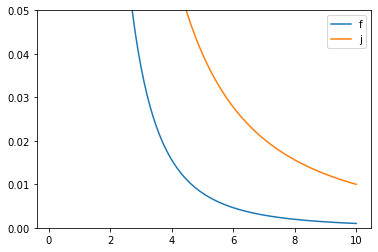

In [8]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 30,40, 50,70]

# 畳み込む関数
def f(x):
    return np.heaviside(x, 1)

def g(x, r):
    return x * (np.heaviside(x - r / alpha, 1) - np.heaviside(x - r / beta, 1)) / r ** 4

# tの値
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# 畳み込み積分用の範囲
x_full = np.linspace(0, 40, len(x) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_x_values = []

# 変位の最大値を取得する
max_values_conv = []
max_x_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_x = np.gradient(f(x), dx)
    g_prime_x = np.gradient(g(x, r), dx)

    # f*g 畳み込み
    conv = signal.convolve(f(x), g(x, r), mode='full') * dx

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dx)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_x_value = x_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_x_values.append(max_x_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_x_value_conv = x_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_x_values_conv.append(max_x_value_conv)

    # Plot 
    axs[0].plot(x_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(x_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/(x-a)**2
def func_3d(x, a, b):
    return b / (x - a)**3

# Use curve_fit to find the best a and b
params, params_covariance = curve_fit(func_3d, max_x_values, max_values)
a_opt, b_opt = params
x_fit = np.linspace(min(max_x_values), max(max_x_values), 500)
y_fit = func_3d(x_fit, a_opt, b_opt)

# Function to fit: y = c/(x-d)**3
def func_2d(x, c, d):
    return c / (x - d)**2

params_conv, params_covariance_conv = curve_fit(func_2d, max_x_values_conv, max_values_conv)
c_opt_conv, d_opt_conv = params_conv
x_fit_conv = np.linspace(min(max_x_values_conv), max(max_x_values_conv), 500)
y_fit_conv = func_2d(x_fit_conv, c_opt_conv, d_opt_conv)

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.set_yticks(np.arange(0, 0.0004, 0.00005))
    ax.grid(True)
    ax.set_xlim([0, 20])
    ax.set_ylim([0, 0.0004])

# Plot max_x_values and max_values
axs[0].scatter(max_x_values, max_values, color='magenta', label='Max points')
axs[0].plot(x_fit, y_fit, color='cyan', label=f'Fitted curve: a={a_opt:.10f}, b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_x_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(x_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): c={c_opt_conv:.10f}, d={d_opt_conv:.10f}')
axs[1].legend()

# Titles
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')  # x軸ラベルを 't' に設定
axs[0].set_ylabel('km/s')  # y軸ラベルを 'km/s' に設定

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')  # x軸ラベルを 't' に設定
axs[1].set_ylabel('km')  # y軸ラベルを 'km/s' に設定
axs[1].set_title("convolution for different r values")


plt.tight_layout()
plt.show()


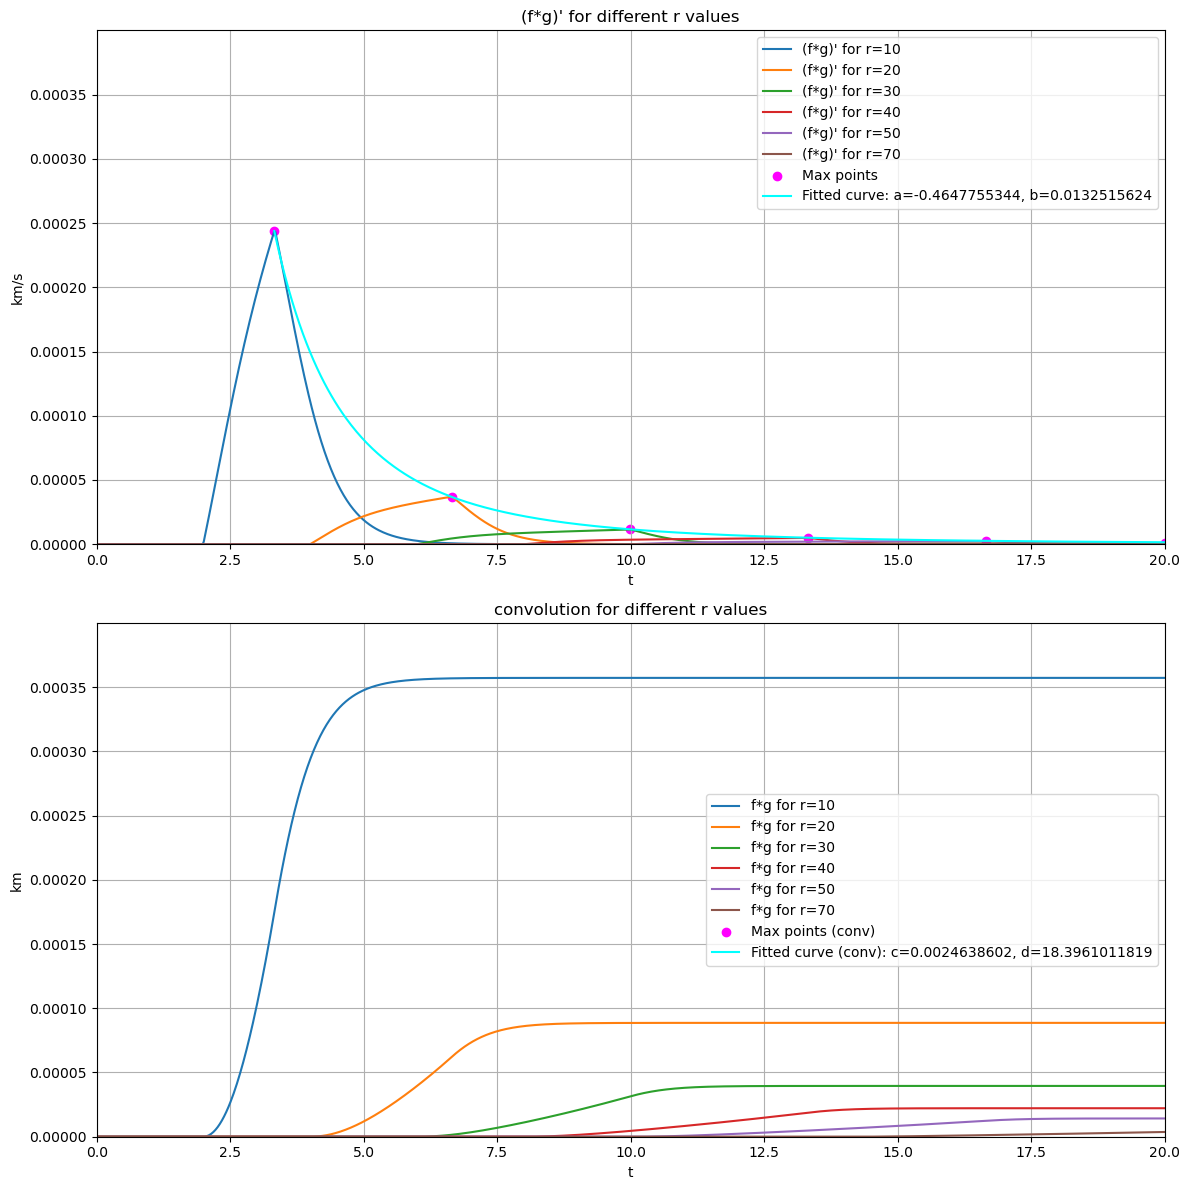

In [9]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 30,40, 50,70]

# 畳み込む関数
def f(x):
    return np.tanh(x)

def g(x, r):
    return x * (np.heaviside(x - r / alpha, 1) - np.heaviside(x - r / beta, 1)) / r ** 4

# tの値
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# 畳み込み積分用の範囲
x_full = np.linspace(0, 40, len(x) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_x_values = []

# 変位の最大値を取得する
max_values_conv = []
max_x_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_x = np.gradient(f(x), dx)
    g_prime_x = np.gradient(g(x, r), dx)

    # f*g 畳み込み
    conv = signal.convolve(f(x), g(x, r), mode='full') * dx

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dx)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_x_value = x_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_x_values.append(max_x_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_x_value_conv = x_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_x_values_conv.append(max_x_value_conv)

    # Plot 
    axs[0].plot(x_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(x_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/(x-a)**2
def func_3d(x, a, b):
    return b / (x - a)**3

# Use curve_fit to find the best a and b
params, params_covariance = curve_fit(func_3d, max_x_values, max_values)
a_opt, b_opt = params
x_fit = np.linspace(min(max_x_values), max(max_x_values), 500)
y_fit = func_3d(x_fit, a_opt, b_opt)

# Function to fit: y = c/(x-d)**3
def func_2d(x, c, d):
    return c / (x - d)**2

params_conv, params_covariance_conv = curve_fit(func_2d, max_x_values_conv, max_values_conv)
c_opt_conv, d_opt_conv = params_conv
x_fit_conv = np.linspace(min(max_x_values_conv), max(max_x_values_conv), 500)
y_fit_conv = func_2d(x_fit_conv, c_opt_conv, d_opt_conv)

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.set_yticks(np.arange(0, 0.0004, 0.00005))
    ax.grid(True)
    ax.set_xlim([0, 20])
    ax.set_ylim([0, 0.0004])

# Plot max_x_values and max_values
axs[0].scatter(max_x_values, max_values, color='magenta', label='Max points')
axs[0].plot(x_fit, y_fit, color='cyan', label=f'Fitted curve: a={a_opt:.10f}, b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_x_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(x_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): c={c_opt_conv:.10f}, d={d_opt_conv:.10f}')
axs[1].legend()

# Titles
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')  # x軸ラベルを 't' に設定
axs[0].set_ylabel('km/s')  # y軸ラベルを 'km/s' に設定

axs[1].set_xlabel('t')  # x軸ラベルを 't' に設定
axs[1].set_ylabel('km')  # y軸ラベルを 'km/s' に設定
axs[1].set_title("convolution for different r values")


plt.tight_layout()
plt.show()


fitする関数の分母は並行移動させない↓

### Q.rの-3乗や-2乗で幾何減衰するとはどういうことか？
t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4
の部分は、rの変化によって位置が変化する。
図を見るに、速度の場合はボックスの位置は[r / alpha,  r / beta]にある。
つまり、r / betaで最大値をとる部分を結んでいる。
r / betaは、当然rの1乗で増加する。
ここで安心しない。速度f*g(t)は、あるrでtの関数。
また別のrになると、その倍率でボックスの位置も変化する。例は以下
#### r = 10なら、t = 3.3に最大、r = 20ではt = 6.6で最大となる。
なので、もしtが1乗で進む中で、速度の値が-3乗に比例していくなら、その値はrの-3乗に比例していると言っていい。

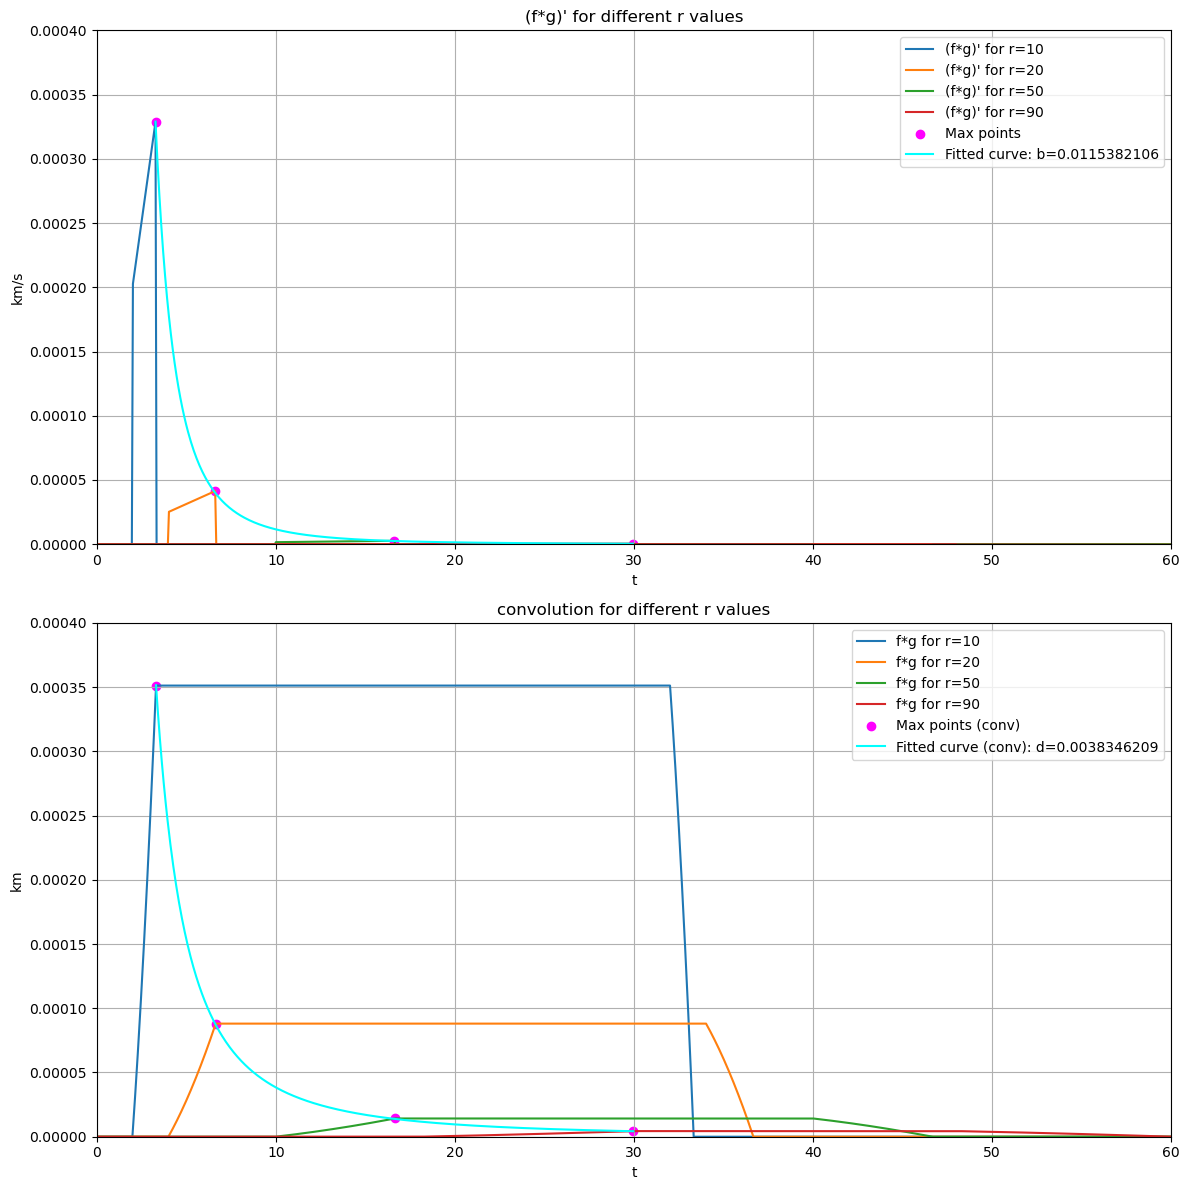

In [16]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 90]

# 畳み込む関数
def f(t):
    return np.heaviside(t, 1)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 30, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 60, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 60])
    ax.set_ylim([0, 0.0004])

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


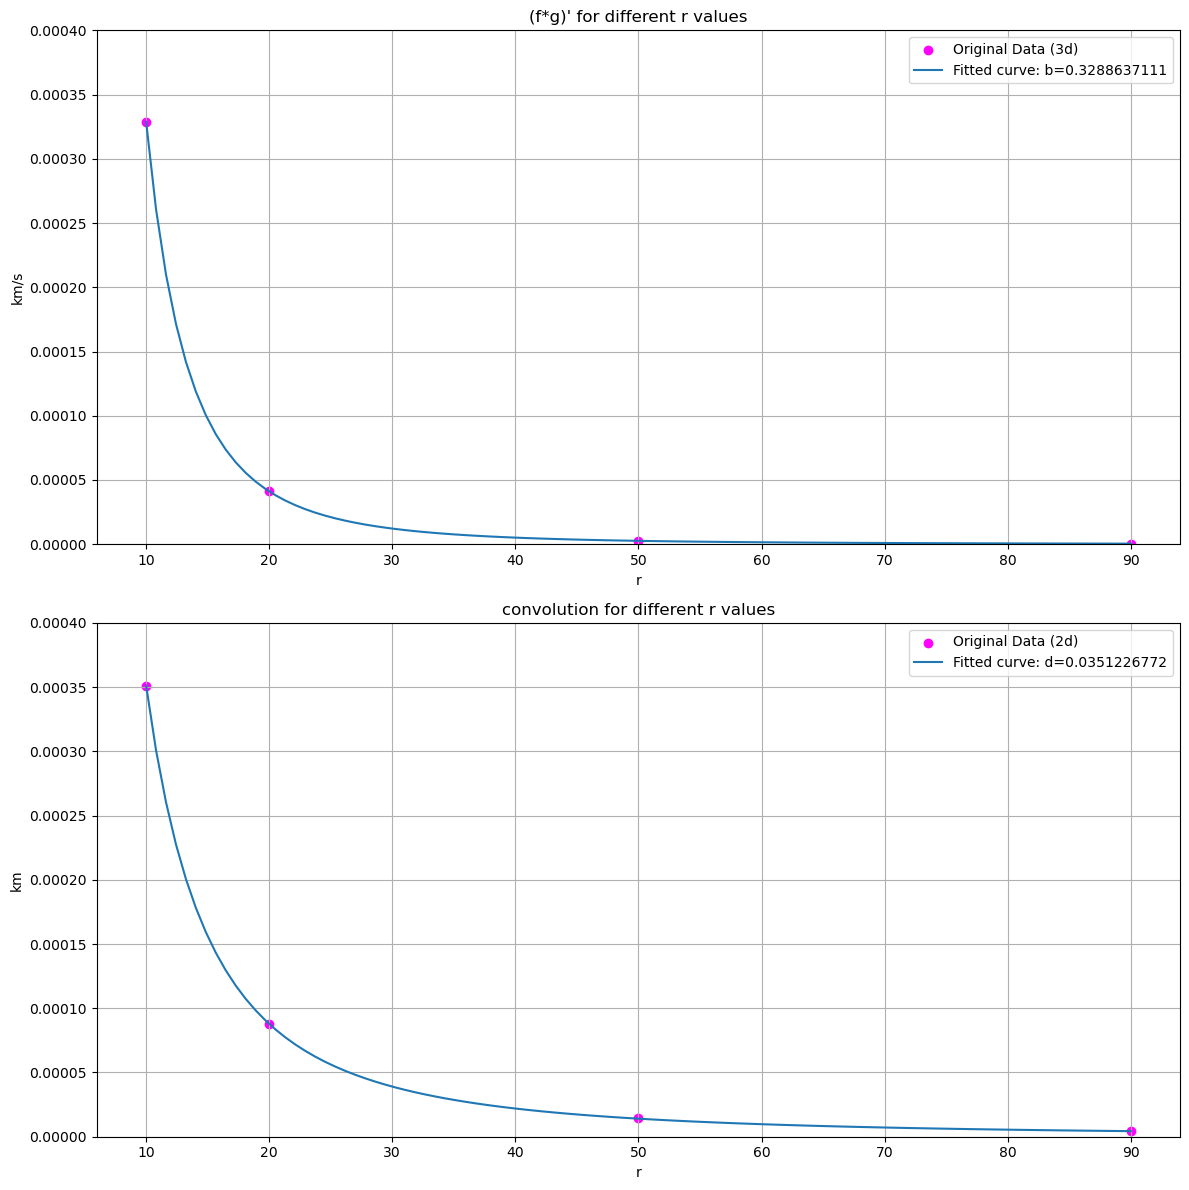

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
r_values_dense = np.linspace(min(r_values), max(r_values), 100)   # 密なxの範囲を生成

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

plt.tight_layout()
plt.show()

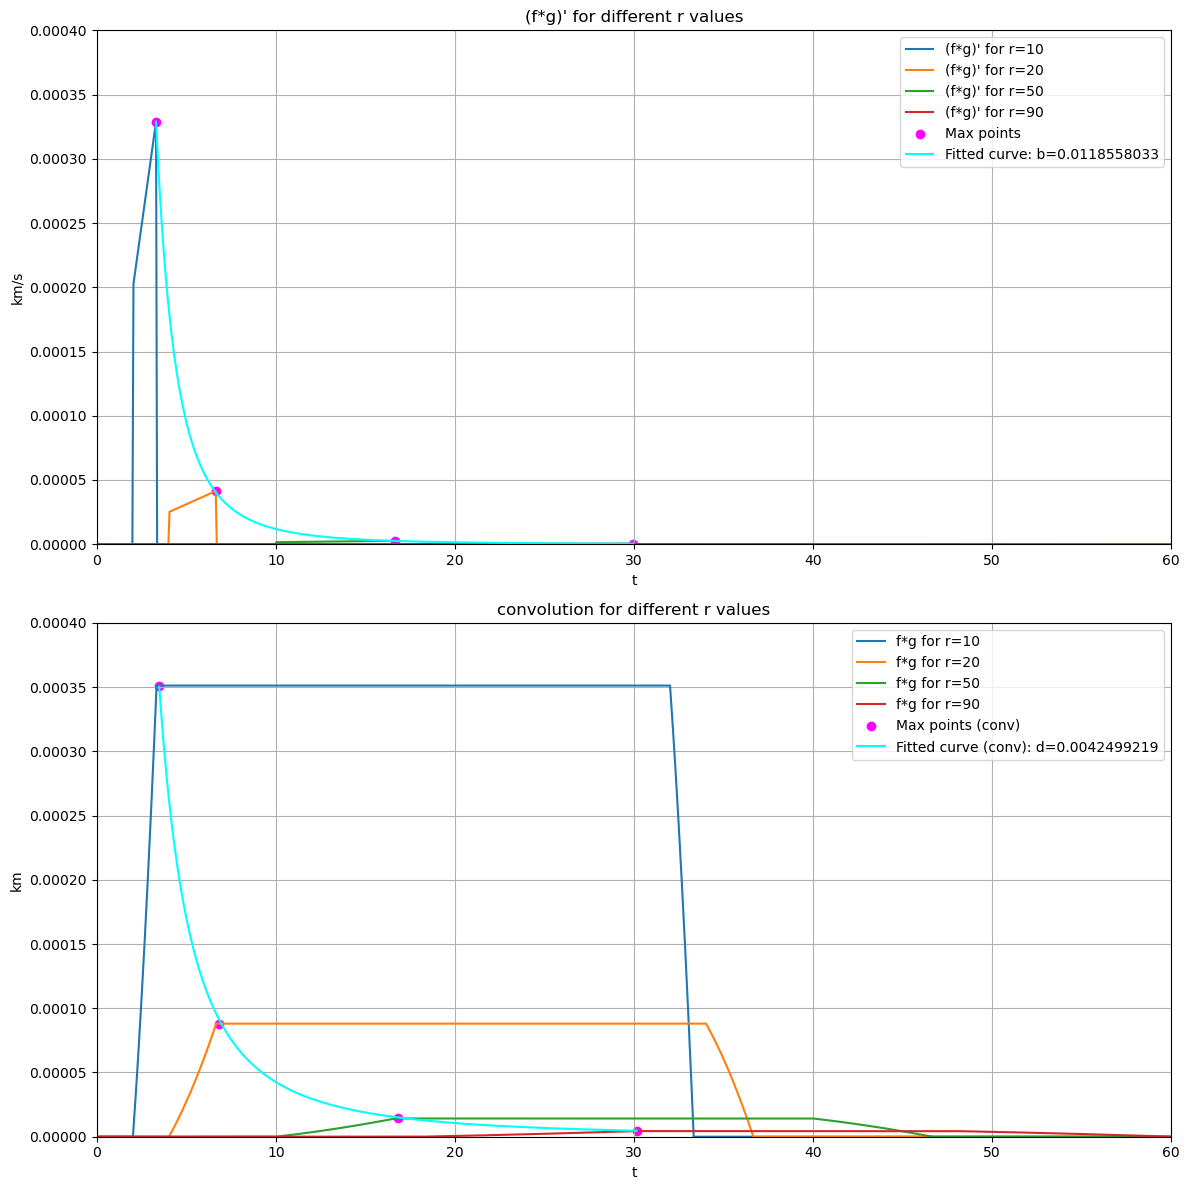

In [18]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 90]

# 畳み込む関数
def f(t):
    return np.tanh(t/0.01)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 30, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 60, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 60])
    ax.set_ylim([0, 0.0004])

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


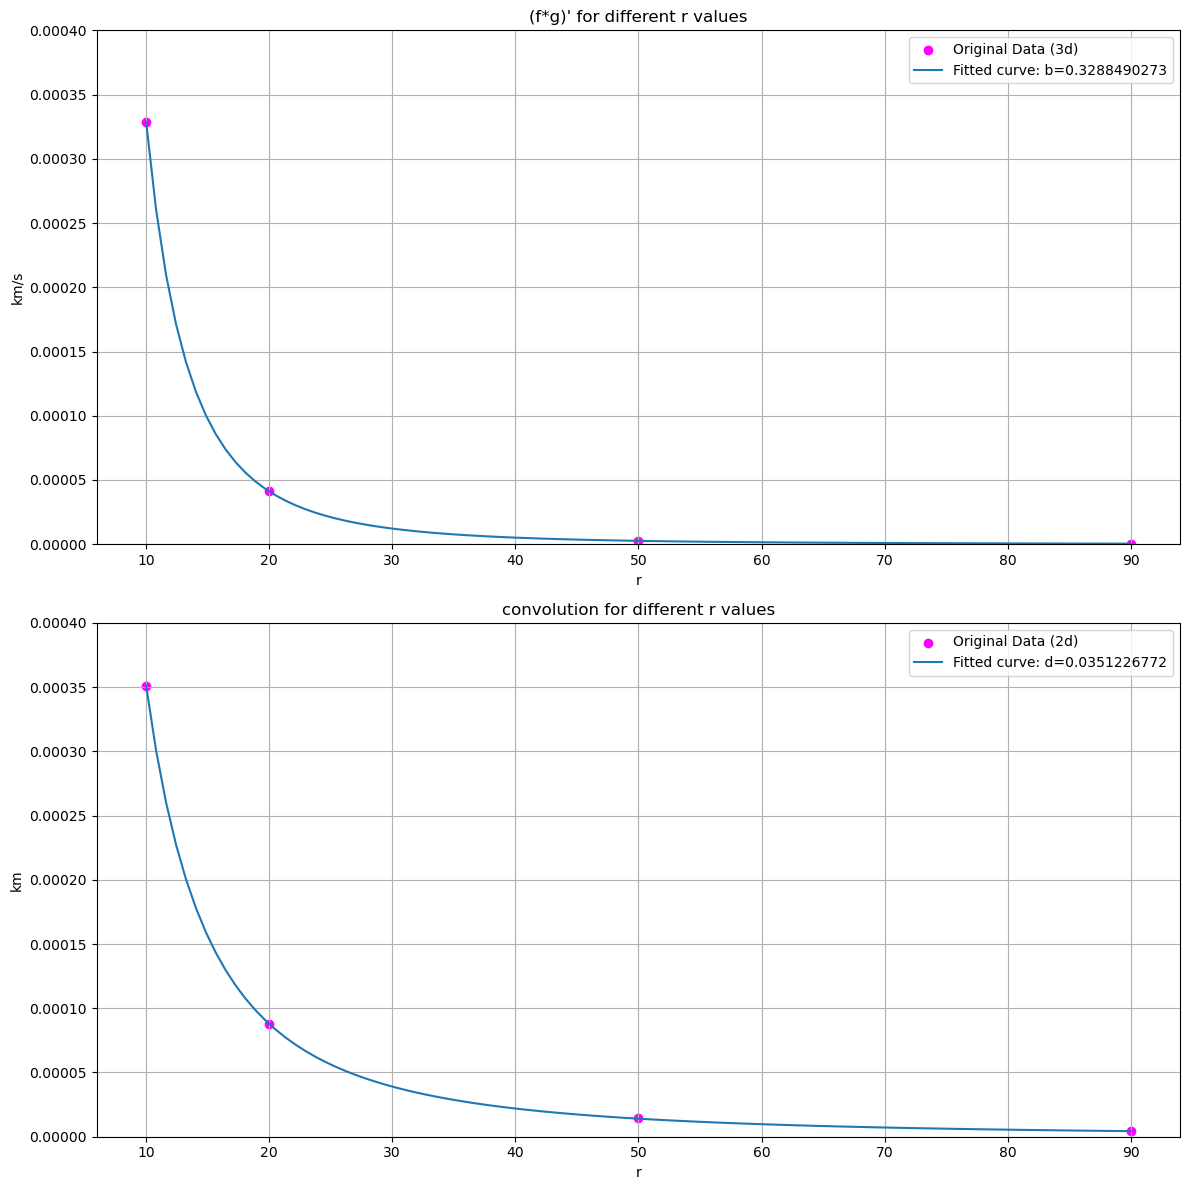

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
r_values_dense = np.linspace(min(r_values), max(r_values), 100)   # 密なxの範囲を生成

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

plt.tight_layout()
plt.show()

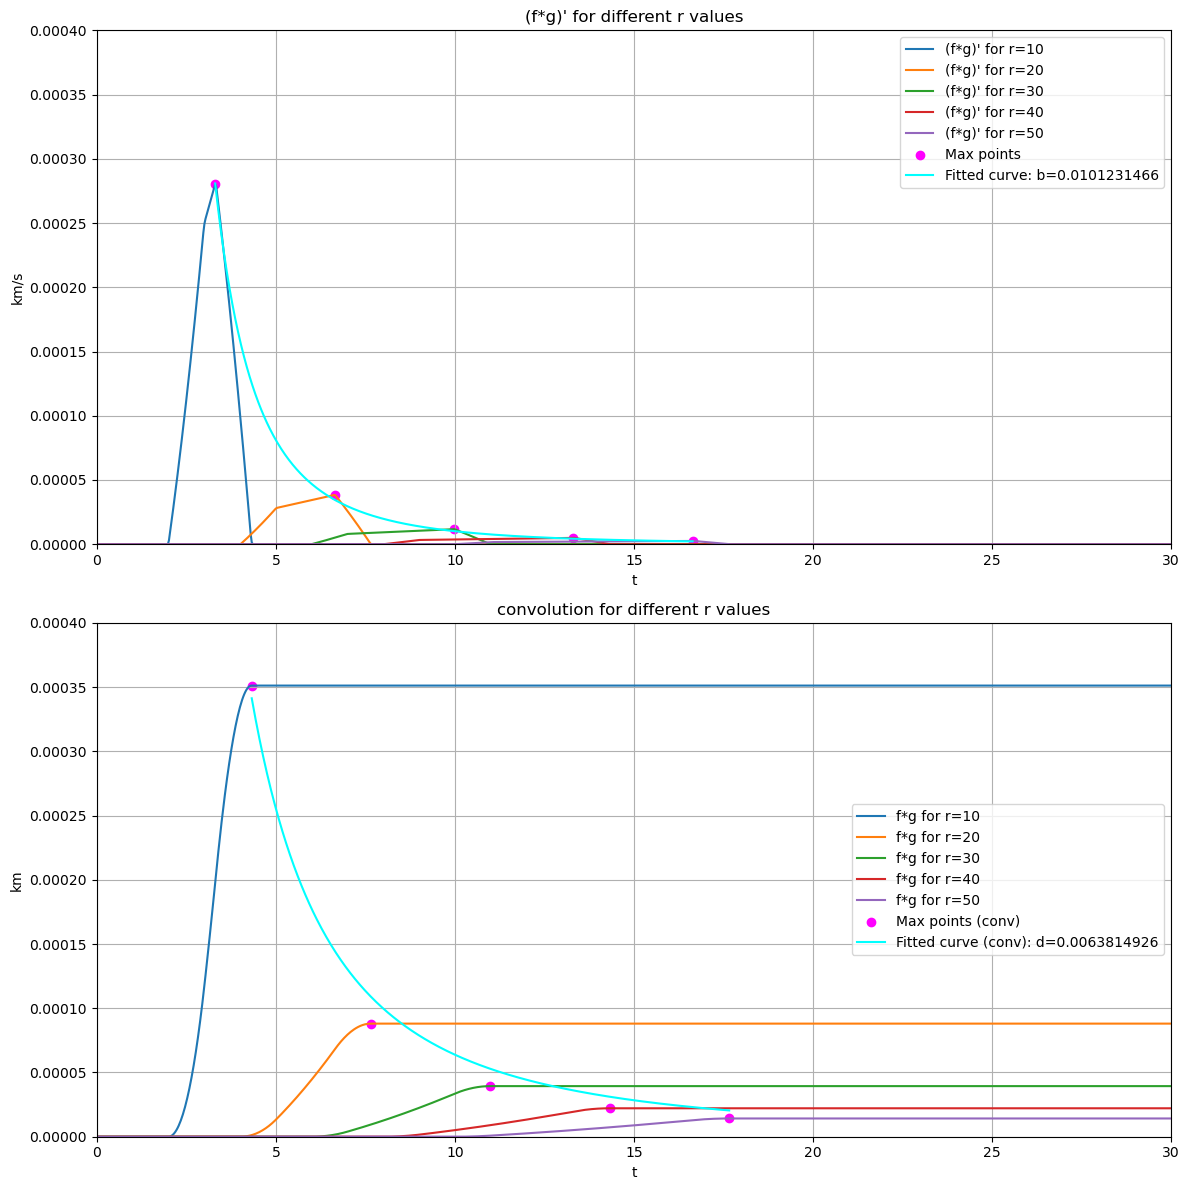

In [20]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 30, 40, 50]

# 畳み込む関数
def f(t):
    result = np.zeros_like(t)
    mask1 = (0 <= t) & (t < 1)
    mask2 = t >= 1
    result[mask1] = t[mask1]
    result[mask2] = 1
    return result

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 30, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 60, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2


params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 30])
    ax.set_ylim([0, 0.0004])

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


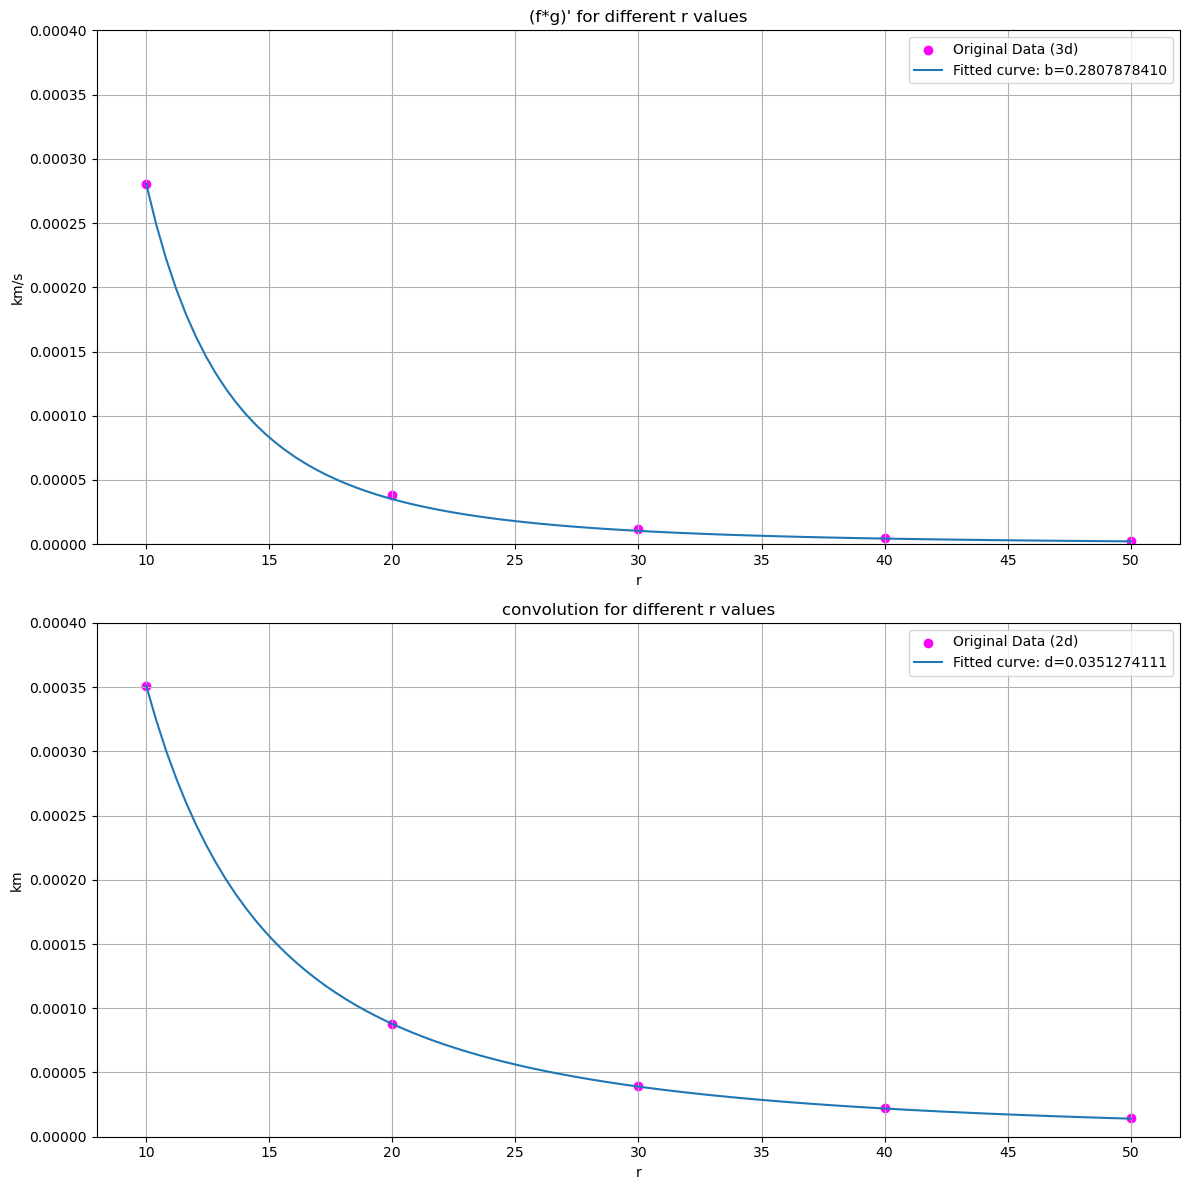

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
r_values_dense = np.linspace(min(r_values), max(r_values), 100)  # 密なxの範囲を生成

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

plt.tight_layout()
plt.show()